# EPM Flow Curve Fitting

**Elasto-Plastic Model (EPM) — Steady-state flow curve with Lattice and Tensorial variants**

## Learning Objectives

- Understand the EPM mesoscopic physics: lattice, Eshelby propagator, plastic avalanches
- Fit steady-state flow curves to real emulsion data using NLSQ with LatticeEPM
- Perform Bayesian inference with NUTS and evaluate convergence
- Use TensorialEPM for forward predictions of normal stress N₁

## Prerequisites

- Basic familiarity with rheological flow curves σ(γ̇)
- Understanding of NLSQ fitting (see `01-basic-maxwell.ipynb`)
- Understanding of Bayesian inference basics (see `05-bayesian-basics.ipynb`)

## Estimated Runtime

- Fast demo (1 chain): ~3-4 min
- Full run (4 chains): ~8-12 min

## 1. Setup & Imports

In [1]:
# Colab setup
import sys

IN_COLAB = "google.colab" in sys.modules

if IN_COLAB:
    %pip install -q rheojax
    import os
    os.environ["JAX_ENABLE_X64"] = "true"
    print("RheoJAX installed successfully.")

In [2]:
%matplotlib inline
import warnings
import time

import arviz as az
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import display

from rheojax.core.jax_config import safe_import_jax, verify_float64
from rheojax.core.data import RheoData
from rheojax.models.epm.lattice import LatticeEPM
from rheojax.models.epm.tensor import TensorialEPM

jax, jnp = safe_import_jax()
verify_float64()

warnings.filterwarnings("ignore", category=FutureWarning)
print(f"JAX version: {jax.__version__}")
print(f"Devices: {jax.devices()}")

def compute_fit_quality(y_true, y_pred):
    """Compute R² and RMSE."""
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)
    residuals = y_true - y_pred
    if y_true.ndim > 1:
        residuals = residuals.ravel()
        y_true = y_true.ravel()
    ss_res = np.sum(residuals**2)
    ss_tot = np.sum((y_true - np.mean(y_true))**2)
    r2 = 1.0 - ss_res / ss_tot if ss_tot > 0 else 0.0
    rmse = np.sqrt(np.mean(residuals**2))
    return {"R2": r2, "RMSE": rmse}

JAX version: 0.8.2
Devices: [CpuDevice(id=0)]


## 2. Theory: EPM Mesoscopic Physics

The **Elasto-Plastic Model (EPM)** is a mesoscopic approach for amorphous solids (glasses, gels, dense emulsions) that explicitly resolves:

1. **Spatial heterogeneity**: A 2D lattice of elastoplastic blocks (L × L)
2. **Plastic avalanches**: Cascading yielding events when local stress exceeds thresholds
3. **Long-range stress redistribution**: Eshelby quadrupolar propagator

### Lattice Dynamics

Each lattice site $i$ has:
- Local stress $\sigma_i$
- Local yield threshold $\sigma_{c,i}$ drawn from a disorder distribution

### Evolution Equation

$$\frac{\partial \sigma_i}{\partial t} = \mu \dot{\gamma} - \frac{\sigma_i}{\tau_{\text{pl}}} \cdot H(|\sigma_i| - \sigma_{c,i}) + \sum_j G_{ij} \cdot \delta\sigma_j^{\text{pl}}$$

where:
- $\mu$: Shear modulus (elastic loading rate)
- $\tau_{\text{pl}}$: Plastic relaxation time
- $H(\cdot)$: Heaviside step function (yielding criterion)
- $G_{ij}$: Eshelby propagator (quadrupolar, $\sim 1/r^2$)

### Disorder Distribution

Yield thresholds follow a Gaussian distribution:

$$\sigma_{c,i} \sim \mathcal{N}(\sigma_{c,\text{mean}}, \sigma_{c,\text{std}}^2)$$

The ratio $\sigma_{c,\text{std}}/\sigma_{c,\text{mean}}$ controls the material's disorder strength:
- Low disorder → sharp yielding, stress localization
- High disorder → gradual yielding, distributed plasticity

### Parameters

| Parameter | Symbol | Physical Meaning | Typical Range |
|-----------|--------|------------------|---------------|
| `mu` | μ | Shear modulus | 0.5–10 Pa |
| `tau_pl` | τ_pl | Plastic relaxation time | 0.1–10 s |
| `sigma_c_mean` | σ_c,mean | Mean yield threshold | 1–50 Pa |
| `sigma_c_std` | σ_c,std | Disorder strength | 0.05–0.5 Pa |

## 3. Load Flow Curve Data

We use a flow curve from a concentrated oil-in-water emulsion (φ = 0.80). This system exhibits:
- A clear yield stress plateau at low shear rates
- Power-law shear-thinning at high rates

This is ideal for EPM, which was designed for amorphous yield-stress materials.

In [3]:
import os

data_path = os.path.join("..", "data", "flow", "emulsions", "0.80.csv")
if IN_COLAB:
    # Download from repository if running in Colab
    data_path = "0.80.csv"
    if not os.path.exists(data_path):
        print("Please upload 0.80.csv or adjust the path.")

raw = np.loadtxt(data_path, delimiter=",", skiprows=1)
gamma_dot = raw[:, 0]  # Shear rate [1/s]
stress = raw[:, 1]      # Stress [Pa]

print(f"Data points: {len(gamma_dot)}")
print(f"Shear rate range: {gamma_dot.min():.4f} – {gamma_dot.max():.1f} 1/s")
print(f"Stress range: {stress.min():.1f} – {stress.max():.1f} Pa")

Data points: 30
Shear rate range: 0.0016 – 978.9 1/s
Stress range: 23.7 – 295.4 Pa


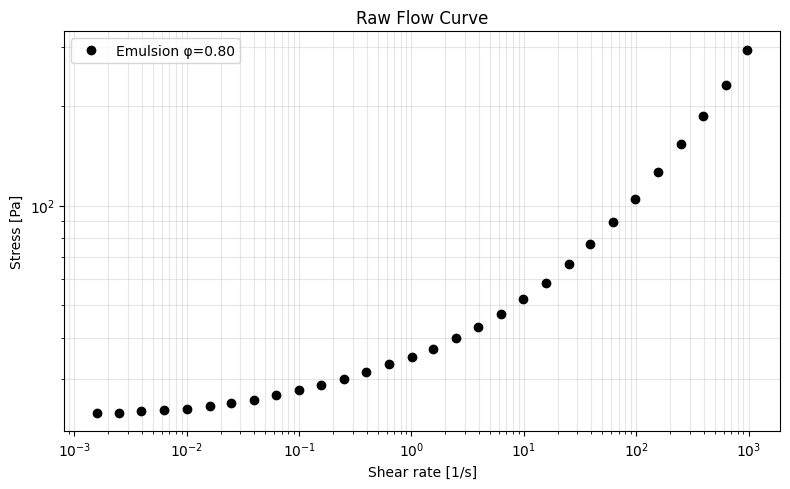

In [4]:
fig, ax = plt.subplots(figsize=(8, 5))
ax.loglog(gamma_dot, stress, "ko", markersize=6, label="Emulsion φ=0.80")
ax.set_xlabel("Shear rate [1/s]")
ax.set_ylabel("Stress [Pa]")
ax.set_title("Raw Flow Curve")
ax.grid(True, alpha=0.3, which="both")
ax.legend()
plt.tight_layout()
display(fig)
plt.close(fig)

The data shows a clear **yield stress plateau** at low shear rates (~24 Pa) transitioning to power-law shear-thinning at high rates. This is classic behavior for concentrated emulsions and is well-captured by EPM physics.

## 4. NLSQ Fitting with LatticeEPM

We use **LatticeEPM** for fitting because it supports the full NLSQ + Bayesian pipeline.

Key settings:
- `L=32`: Lattice size (smaller for faster fitting, 64+ for production)
- `smooth=True`: Differentiable yielding for gradient-based optimization

In [5]:
# FAST mode for batch testing (L=16, reduced samples)
# Set to False for full-resolution production runs
FAST_MODE = True

# Initialize LatticeEPM
model = LatticeEPM(
    L=16 if FAST_MODE else 32,  # FAST: L=16, FULL: L=32
    dt=0.01,   # Time step
    mu=1.0,
    tau_pl=1.0,
    sigma_c_mean=1.0,
    sigma_c_std=0.1,
)

# Set physically motivated bounds
model.parameters["mu"].bounds = (0.1, 20.0)
model.parameters["tau_pl"].bounds = (0.01, 50.0)
model.parameters["sigma_c_mean"].bounds = (0.5, 100.0)
model.parameters["sigma_c_std"].bounds = (0.01, 10.0)

print("LatticeEPM initialized")
print(f"  Lattice size: {model.L}×{model.L}")
print(f"  Parameters: {list(model.parameters.keys())}")

LatticeEPM initialized
  Lattice size: 16×16
  Parameters: ['mu', 'tau_pl', 'sigma_c_mean', 'sigma_c_std', 'smoothing_width']


In [6]:
# Fit to flow curve
t0 = time.time()
model.fit(gamma_dot, stress, test_mode="flow_curve", method='scipy')
t_nlsq = time.time() - t0

# Compute fit quality
y_pred = model.predict(gamma_dot, test_mode="flow_curve", smooth=True).y
metrics = compute_fit_quality(stress, y_pred)

print(f"NLSQ fit time: {t_nlsq:.2f} s")
print(f"R²: {metrics['R2']:.6f}")
print(f"RMSE: {metrics['RMSE']:.4f} Pa")
print("\nFitted parameters:")
for name in ["mu", "tau_pl", "sigma_c_mean", "sigma_c_std"]:
    val = model.parameters.get_value(name)
    print(f"  {name:15s} = {val:.4g}")

INFO:nlsq.least_squares:Starting least squares optimization method=trf | n_params=5 | loss=linear | ftol=1.0000e-06 | xtol=1.0000e-06 | gtol=1.0000e-06


PERFORMANCE:nlsq.least_squares:Timer: optimization elapsed=5.101572s


INFO:nlsq.least_squares:Convergence reason=`ftol` termination condition is satisfied. | iterations=11 | final_cost=5.8644 | elapsed=5.102s | final_gradient_norm=0.0814


NLSQ fit time: 9.21 s
R²: 0.898973
RMSE: 21.1714 Pa

Fitted parameters:
  mu              = 20
  tau_pl          = 0.3656
  sigma_c_mean    = 93.13
  sigma_c_std     = 0.2218


## 5. Parameter Interpretation

The fitted EPM parameters have direct physical meaning:

- **μ (shear modulus)**: Controls the elastic loading rate. Higher μ means faster stress buildup.
- **τ_pl (plastic time)**: Controls how quickly plastic events relax. Shorter τ_pl means faster plastic flow.
- **σ_c,mean (mean yield threshold)**: The average stress required for local yielding. Directly related to the macroscopic yield stress.
- **σ_c,std (disorder strength)**: Controls the width of the yield threshold distribution. Higher values mean more gradual yielding.

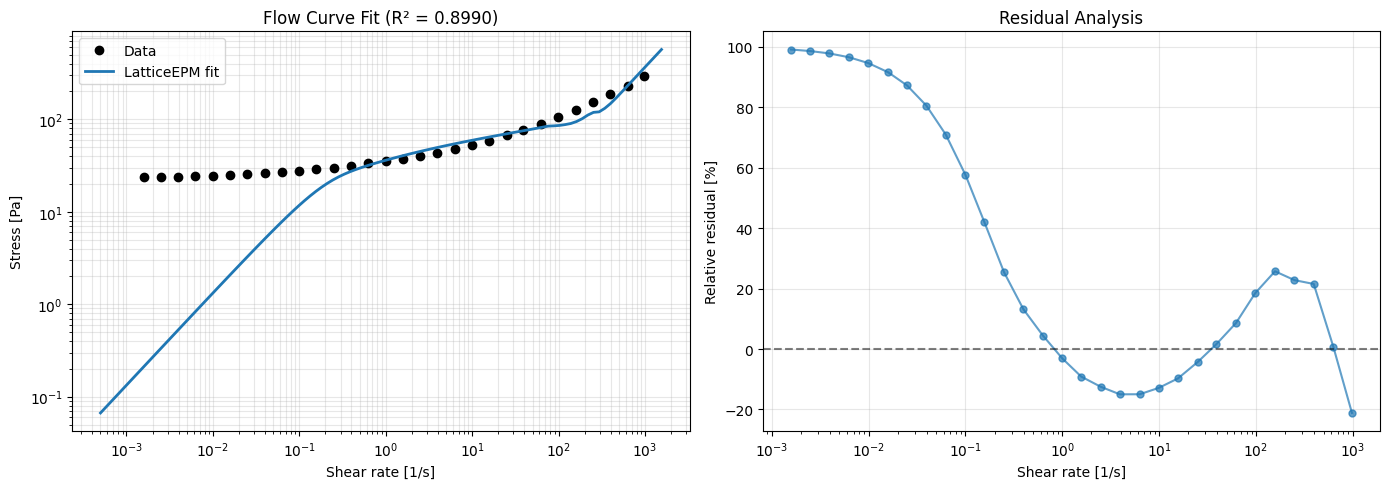

In [7]:
# Predict and plot fit quality
gamma_dot_fine = np.logspace(
    np.log10(gamma_dot.min()) - 0.5,
    np.log10(gamma_dot.max()) + 0.2,
    100,
)
stress_pred = model.predict(gamma_dot_fine, test_mode="flow_curve", smooth=True).y

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Left: flow curve
ax1.loglog(gamma_dot, stress, "ko", markersize=6, label="Data")
ax1.loglog(gamma_dot_fine, stress_pred, "-", lw=2, color="C0", label="LatticeEPM fit")
ax1.set_xlabel("Shear rate [1/s]")
ax1.set_ylabel("Stress [Pa]")
ax1.set_title(f"Flow Curve Fit (R² = {metrics['R2']:.4f})")
ax1.legend()
ax1.grid(True, alpha=0.3, which="both")

# Right: residuals
stress_at_data = model.predict(gamma_dot, test_mode="flow_curve", smooth=True).y
residuals = (stress - np.array(stress_at_data)) / stress * 100

ax2.semilogx(gamma_dot, residuals, "o-", markersize=5, alpha=0.7)
ax2.axhline(0, color="black", linestyle="--", alpha=0.5)
ax2.set_xlabel("Shear rate [1/s]")
ax2.set_ylabel("Relative residual [%]")
ax2.set_title("Residual Analysis")
ax2.grid(True, alpha=0.3)

plt.tight_layout()
display(fig)
plt.close(fig)

## 6. Bayesian Inference with NUTS

We use the NLSQ estimates as a **warm-start** for NUTS sampling. This is critical for EPM because:
1. The parameter space is complex with correlations between μ, τ_pl, and σ_c
2. The forward model is computationally expensive (lattice simulation)
3. Warm-start dramatically reduces the required warmup iterations

In [8]:
# Warm-start values from NLSQ
initial_values = {
    name: model.parameters.get_value(name)
    for name in model.parameters.keys()
}
print("Warm-start values:")
for k, v in initial_values.items():
    print(f"  {k}: {v:.4g}")

Warm-start values:
  mu: 20
  tau_pl: 0.3656
  sigma_c_mean: 93.13
  sigma_c_std: 0.2218
  smoothing_width: 24.94


In [9]:
# --- Fast demo config (change to 4 chains for production) ---
# Bayesian config: FAST (100/200/1) for batch, FULL (200/500/1) for demos
NUM_WARMUP = 50 if FAST_MODE else 200
NUM_SAMPLES = 100 if FAST_MODE else 500
NUM_CHAINS = 1
# NUM_WARMUP = 1000; NUM_SAMPLES = 2000; NUM_CHAINS = 4  # production

print(f"Running Bayesian inference: {NUM_CHAINS} chain(s), {NUM_WARMUP} warmup, {NUM_SAMPLES} samples")

t0 = time.time()
result = model.fit_bayesian(
    gamma_dot,
    stress,
    test_mode="flow_curve",
    num_warmup=NUM_WARMUP,
    num_samples=NUM_SAMPLES,
    num_chains=NUM_CHAINS,
    initial_values=initial_values,
    seed=42,
)
t_bayes = time.time() - t0
print(f"\nBayesian inference time: {t_bayes:.1f} s")

Running Bayesian inference: 1 chain(s), 50 warmup, 100 samples


  0%|          | 0/150 [00:00<?, ?it/s]

warmup:   1%|          | 1/150 [00:02<06:04,  2.45s/it, 1 steps of size 1.65e+00. acc. prob=0.00]

warmup:   2%|▏         | 3/150 [00:02<01:41,  1.45it/s, 1 steps of size 3.66e-03. acc. prob=0.00]

warmup:   3%|▎         | 4/150 [00:03<01:59,  1.22it/s, 15 steps of size 1.45e-03. acc. prob=0.22]

warmup:   3%|▎         | 5/150 [00:04<02:10,  1.11it/s, 15 steps of size 8.90e-04. acc. prob=0.36]

warmup:   4%|▍         | 6/150 [00:09<05:14,  2.18s/it, 63 steps of size 4.87e-04. acc. prob=0.45]

warmup:   5%|▍         | 7/150 [00:19<10:36,  4.45s/it, 127 steps of size 4.18e-04. acc. prob=0.53]

warmup:   5%|▌         | 8/150 [00:57<35:12, 14.88s/it, 511 steps of size 3.82e-04. acc. prob=0.59]

warmup:   6%|▌         | 9/150 [01:33<50:31, 21.50s/it, 511 steps of size 3.74e-04. acc. prob=0.63]

warmup:   7%|▋         | 10/150 [01:37<38:00, 16.29s/it, 63 steps of size 3.53e-04. acc. prob=0.67]

warmup:   7%|▋         | 11/150 [02:47<1:15:24, 32.55s/it, 1023 steps of size 2.10e-04. acc. prob=0.68]

warmup:   8%|▊         | 12/150 [03:44<1:31:20, 39.72s/it, 808 steps of size 2.09e-04. acc. prob=0.70] 

warmup:   9%|▊         | 13/150 [04:53<1:51:21, 48.77s/it, 1023 steps of size 2.26e-04. acc. prob=0.73]

warmup:   9%|▉         | 14/150 [05:59<2:02:19, 53.97s/it, 1023 steps of size 2.41e-04. acc. prob=0.75]

warmup:  10%|█         | 15/150 [07:06<2:09:59, 57.78s/it, 1023 steps of size 2.49e-04. acc. prob=0.76]

warmup:  11%|█         | 16/150 [08:20<2:20:14, 62.80s/it, 1023 steps of size 2.58e-05. acc. prob=0.73]

warmup:  11%|█▏        | 17/150 [09:39<2:29:57, 67.65s/it, 1023 steps of size 2.89e-05. acc. prob=0.74]

warmup:  12%|█▏        | 18/150 [10:51<2:31:28, 68.85s/it, 1023 steps of size 3.29e-05. acc. prob=0.76]

warmup:  13%|█▎        | 19/150 [11:59<2:29:45, 68.59s/it, 1023 steps of size 3.75e-05. acc. prob=0.77]

warmup:  13%|█▎        | 20/150 [13:07<2:27:53, 68.25s/it, 1023 steps of size 4.28e-05. acc. prob=0.78]

warmup:  14%|█▍        | 21/150 [14:16<2:27:33, 68.63s/it, 1023 steps of size 4.64e-05. acc. prob=0.79]

warmup:  15%|█▍        | 22/150 [15:23<2:25:09, 68.04s/it, 1023 steps of size 5.26e-05. acc. prob=0.80]

warmup:  15%|█▌        | 23/150 [16:30<2:23:23, 67.74s/it, 1023 steps of size 5.48e-05. acc. prob=0.81]

warmup:  16%|█▌        | 24/150 [17:41<2:24:45, 68.94s/it, 1023 steps of size 6.22e-05. acc. prob=0.82]

warmup:  17%|█▋        | 25/150 [18:51<2:23:59, 69.11s/it, 1023 steps of size 6.98e-05. acc. prob=0.82]

warmup:  17%|█▋        | 26/150 [19:57<2:20:55, 68.19s/it, 1023 steps of size 7.93e-05. acc. prob=0.83]

warmup:  18%|█▊        | 27/150 [21:07<2:21:06, 68.84s/it, 1023 steps of size 9.01e-05. acc. prob=0.84]

warmup:  19%|█▊        | 28/150 [22:17<2:20:16, 68.99s/it, 1023 steps of size 1.02e-04. acc. prob=0.84]

warmup:  19%|█▉        | 29/150 [23:23<2:17:27, 68.16s/it, 1023 steps of size 1.15e-04. acc. prob=0.85]

warmup:  20%|██        | 30/150 [24:32<2:17:03, 68.53s/it, 1023 steps of size 1.30e-04. acc. prob=0.85]

warmup:  21%|██        | 31/150 [25:38<2:14:21, 67.75s/it, 1023 steps of size 1.42e-04. acc. prob=0.86]

warmup:  21%|██▏       | 32/150 [26:46<2:13:21, 67.81s/it, 1023 steps of size 1.60e-04. acc. prob=0.86]

warmup:  22%|██▏       | 33/150 [28:00<2:15:41, 69.58s/it, 1023 steps of size 1.78e-04. acc. prob=0.87]

warmup:  23%|██▎       | 34/150 [29:10<2:14:50, 69.75s/it, 1023 steps of size 1.63e-04. acc. prob=0.87]

warmup:  23%|██▎       | 35/150 [30:17<2:11:51, 68.80s/it, 1023 steps of size 1.81e-04. acc. prob=0.87]

warmup:  24%|██▍       | 36/150 [31:27<2:11:23, 69.15s/it, 1023 steps of size 1.91e-04. acc. prob=0.87]

warmup:  25%|██▍       | 37/150 [32:42<2:13:48, 71.05s/it, 1023 steps of size 2.11e-04. acc. prob=0.88]

warmup:  25%|██▌       | 38/150 [33:57<2:14:40, 72.15s/it, 1023 steps of size 2.05e-04. acc. prob=0.88]

warmup:  26%|██▌       | 39/150 [35:09<2:13:20, 72.07s/it, 1023 steps of size 2.22e-04. acc. prob=0.88]

warmup:  27%|██▋       | 40/150 [36:19<2:11:00, 71.46s/it, 1023 steps of size 2.47e-04. acc. prob=0.89]

warmup:  27%|██▋       | 41/150 [37:26<2:07:40, 70.28s/it, 1023 steps of size 2.58e-04. acc. prob=0.89]

warmup:  28%|██▊       | 42/150 [38:37<2:06:32, 70.30s/it, 1023 steps of size 1.87e-04. acc. prob=0.89]

warmup:  29%|██▊       | 43/150 [39:44<2:04:03, 69.57s/it, 1023 steps of size 2.06e-04. acc. prob=0.89]

warmup:  29%|██▉       | 44/150 [40:54<2:03:06, 69.68s/it, 1023 steps of size 2.28e-04. acc. prob=0.89]

warmup:  30%|███       | 45/150 [42:04<2:01:45, 69.57s/it, 1023 steps of size 2.52e-04. acc. prob=0.89]

warmup:  31%|███       | 46/150 [43:14<2:01:04, 69.85s/it, 1023 steps of size 2.57e-03. acc. prob=0.90]

warmup:  31%|███▏      | 47/150 [44:20<1:57:59, 68.74s/it, 1023 steps of size 2.61e-03. acc. prob=0.90]

warmup:  32%|███▏      | 48/150 [45:33<1:58:39, 69.80s/it, 1023 steps of size 2.69e-03. acc. prob=0.90]

warmup:  33%|███▎      | 49/150 [46:42<1:57:08, 69.59s/it, 1023 steps of size 2.71e-03. acc. prob=0.90]

warmup:  33%|███▎      | 50/150 [47:49<1:54:33, 68.74s/it, 1023 steps of size 2.69e-03. acc. prob=0.90]

sample:  34%|███▍      | 51/150 [48:59<1:54:13, 69.22s/it, 1023 steps of size 2.69e-03. acc. prob=1.00]

sample:  35%|███▍      | 52/150 [50:04<1:51:09, 68.06s/it, 1023 steps of size 2.69e-03. acc. prob=1.00]

sample:  35%|███▌      | 53/150 [51:15<1:51:26, 68.93s/it, 1023 steps of size 2.69e-03. acc. prob=0.97]

sample:  36%|███▌      | 54/150 [52:28<1:51:59, 70.00s/it, 1023 steps of size 2.69e-03. acc. prob=0.98]

sample:  37%|███▋      | 55/150 [53:33<1:48:45, 68.69s/it, 1023 steps of size 2.69e-03. acc. prob=0.98]

sample:  37%|███▋      | 56/150 [54:37<1:45:10, 67.13s/it, 1023 steps of size 2.69e-03. acc. prob=0.98]

sample:  38%|███▊      | 57/150 [55:46<1:44:55, 67.69s/it, 1023 steps of size 2.69e-03. acc. prob=0.99]

sample:  39%|███▊      | 58/150 [56:57<1:45:12, 68.61s/it, 1023 steps of size 2.69e-03. acc. prob=0.99]

sample:  39%|███▉      | 59/150 [58:03<1:43:10, 68.03s/it, 1023 steps of size 2.69e-03. acc. prob=0.98]

sample:  40%|████      | 60/150 [59:12<1:42:35, 68.40s/it, 1023 steps of size 2.69e-03. acc. prob=0.99]

sample:  41%|████      | 61/150 [1:00:21<1:41:40, 68.54s/it, 1023 steps of size 2.69e-03. acc. prob=0.98]

sample:  41%|████▏     | 62/150 [1:01:29<1:40:07, 68.27s/it, 1023 steps of size 2.69e-03. acc. prob=0.98]

sample:  42%|████▏     | 63/150 [1:02:39<1:39:56, 68.92s/it, 1023 steps of size 2.69e-03. acc. prob=0.99]

sample:  43%|████▎     | 64/150 [1:03:46<1:37:52, 68.28s/it, 1023 steps of size 2.69e-03. acc. prob=0.99]

sample:  43%|████▎     | 65/150 [1:04:52<1:35:42, 67.56s/it, 1023 steps of size 2.69e-03. acc. prob=0.99]

sample:  44%|████▍     | 66/150 [1:06:21<1:43:36, 74.01s/it, 1023 steps of size 2.69e-03. acc. prob=0.99]

sample:  45%|████▍     | 67/150 [1:07:38<1:43:44, 75.00s/it, 1023 steps of size 2.69e-03. acc. prob=0.99]

sample:  45%|████▌     | 68/150 [1:08:44<1:38:46, 72.27s/it, 1023 steps of size 2.69e-03. acc. prob=0.99]

sample:  46%|████▌     | 69/150 [1:09:57<1:37:37, 72.32s/it, 1023 steps of size 2.69e-03. acc. prob=0.99]

sample:  47%|████▋     | 70/150 [1:11:10<1:36:51, 72.65s/it, 1023 steps of size 2.69e-03. acc. prob=0.99]

sample:  47%|████▋     | 71/150 [1:12:23<1:35:42, 72.69s/it, 1023 steps of size 2.69e-03. acc. prob=0.99]

sample:  48%|████▊     | 72/150 [1:13:27<1:31:06, 70.08s/it, 943 steps of size 2.69e-03. acc. prob=0.99] 

sample:  49%|████▊     | 73/150 [1:14:34<1:28:35, 69.03s/it, 1023 steps of size 2.69e-03. acc. prob=0.99]

sample:  49%|████▉     | 74/150 [1:14:50<1:07:32, 53.32s/it, 255 steps of size 2.69e-03. acc. prob=0.96] 

sample:  50%|█████     | 75/150 [1:15:08<53:23, 42.71s/it, 255 steps of size 2.69e-03. acc. prob=0.93]  

sample:  51%|█████     | 76/150 [1:16:18<1:02:45, 50.89s/it, 1023 steps of size 2.69e-03. acc. prob=0.93]

sample:  51%|█████▏    | 77/150 [1:17:27<1:08:26, 56.25s/it, 1023 steps of size 2.69e-03. acc. prob=0.92]

sample:  52%|█████▏    | 78/150 [1:18:35<1:11:49, 59.85s/it, 1023 steps of size 2.69e-03. acc. prob=0.92]

sample:  53%|█████▎    | 79/150 [1:19:47<1:15:01, 63.40s/it, 1023 steps of size 2.69e-03. acc. prob=0.92]

sample:  53%|█████▎    | 80/150 [1:20:55<1:15:39, 64.85s/it, 1023 steps of size 2.69e-03. acc. prob=0.92]

sample:  54%|█████▍    | 81/150 [1:22:08<1:17:29, 67.39s/it, 1023 steps of size 2.69e-03. acc. prob=0.93]

sample:  55%|█████▍    | 82/150 [1:23:21<1:18:02, 68.86s/it, 1023 steps of size 2.69e-03. acc. prob=0.93]

sample:  55%|█████▌    | 83/150 [1:24:28<1:16:11, 68.24s/it, 1023 steps of size 2.69e-03. acc. prob=0.93]

sample:  56%|█████▌    | 84/150 [1:25:38<1:15:53, 68.99s/it, 1023 steps of size 2.69e-03. acc. prob=0.93]

sample:  57%|█████▋    | 85/150 [1:26:45<1:14:01, 68.33s/it, 1023 steps of size 2.69e-03. acc. prob=0.93]

sample:  57%|█████▋    | 86/150 [1:27:52<1:12:19, 67.80s/it, 1023 steps of size 2.69e-03. acc. prob=0.94]

sample:  58%|█████▊    | 87/150 [1:29:07<1:13:35, 70.09s/it, 1023 steps of size 2.69e-03. acc. prob=0.94]

sample:  59%|█████▊    | 88/150 [1:30:14<1:11:30, 69.20s/it, 1023 steps of size 2.69e-03. acc. prob=0.94]

sample:  59%|█████▉    | 89/150 [1:31:29<1:12:00, 70.82s/it, 1023 steps of size 2.69e-03. acc. prob=0.94]

sample:  60%|██████    | 90/150 [1:32:04<1:00:09, 60.16s/it, 511 steps of size 2.69e-03. acc. prob=0.94] 

sample:  61%|██████    | 91/150 [1:33:17<1:02:48, 63.88s/it, 1023 steps of size 2.69e-03. acc. prob=0.94]

sample:  61%|██████▏   | 92/150 [1:34:39<1:07:06, 69.43s/it, 1023 steps of size 2.69e-03. acc. prob=0.94]

sample:  62%|██████▏   | 93/150 [1:35:52<1:07:06, 70.63s/it, 1023 steps of size 2.69e-03. acc. prob=0.95]

sample:  63%|██████▎   | 94/150 [1:37:04<1:06:14, 70.97s/it, 1023 steps of size 2.69e-03. acc. prob=0.95]

sample:  63%|██████▎   | 95/150 [1:37:59<1:00:31, 66.02s/it, 743 steps of size 2.69e-03. acc. prob=0.95] 

sample:  64%|██████▍   | 96/150 [1:39:10<1:00:51, 67.63s/it, 1023 steps of size 2.69e-03. acc. prob=0.95]

sample:  65%|██████▍   | 97/150 [1:40:30<1:03:03, 71.39s/it, 1023 steps of size 2.69e-03. acc. prob=0.95]

sample:  65%|██████▌   | 98/150 [1:41:43<1:02:18, 71.90s/it, 1023 steps of size 2.69e-03. acc. prob=0.95]

sample:  66%|██████▌   | 99/150 [1:42:58<1:01:44, 72.63s/it, 1023 steps of size 2.69e-03. acc. prob=0.95]

sample:  67%|██████▋   | 100/150 [1:44:14<1:01:23, 73.67s/it, 1023 steps of size 2.69e-03. acc. prob=0.95]

sample:  67%|██████▋   | 101/150 [1:45:24<59:26, 72.78s/it, 1023 steps of size 2.69e-03. acc. prob=0.95]  

sample:  68%|██████▊   | 102/150 [1:46:40<58:47, 73.49s/it, 1023 steps of size 2.69e-03. acc. prob=0.95]

sample:  69%|██████▊   | 103/150 [1:47:54<57:46, 73.76s/it, 1023 steps of size 2.69e-03. acc. prob=0.95]

sample:  69%|██████▉   | 104/150 [1:49:05<55:55, 72.94s/it, 1023 steps of size 2.69e-03. acc. prob=0.95]

sample:  70%|███████   | 105/150 [1:50:25<56:21, 75.15s/it, 1023 steps of size 2.69e-03. acc. prob=0.96]

sample:  71%|███████   | 106/150 [1:51:47<56:37, 77.22s/it, 1023 steps of size 2.69e-03. acc. prob=0.96]

sample:  71%|███████▏  | 107/150 [1:53:02<54:51, 76.54s/it, 1023 steps of size 2.69e-03. acc. prob=0.96]

sample:  72%|███████▏  | 108/150 [1:54:14<52:39, 75.21s/it, 1023 steps of size 2.69e-03. acc. prob=0.96]

sample:  73%|███████▎  | 109/150 [1:55:29<51:12, 74.94s/it, 1023 steps of size 2.69e-03. acc. prob=0.96]

sample:  73%|███████▎  | 110/150 [1:56:42<49:33, 74.34s/it, 1023 steps of size 2.69e-03. acc. prob=0.96]

sample:  74%|███████▍  | 111/150 [1:57:55<48:09, 74.10s/it, 1023 steps of size 2.69e-03. acc. prob=0.96]

sample:  75%|███████▍  | 112/150 [1:59:09<46:47, 73.88s/it, 1023 steps of size 2.69e-03. acc. prob=0.96]

sample:  75%|███████▌  | 113/150 [2:00:22<45:31, 73.83s/it, 1023 steps of size 2.69e-03. acc. prob=0.96]

sample:  76%|███████▌  | 114/150 [2:01:37<44:29, 74.16s/it, 1023 steps of size 2.69e-03. acc. prob=0.94]

sample:  77%|███████▋  | 115/150 [2:02:13<36:34, 62.69s/it, 511 steps of size 2.69e-03. acc. prob=0.93] 

sample:  77%|███████▋  | 116/150 [2:03:26<37:13, 65.68s/it, 1023 steps of size 2.69e-03. acc. prob=0.93]

sample:  78%|███████▊  | 117/150 [2:03:44<28:13, 51.32s/it, 268 steps of size 2.69e-03. acc. prob=0.92] 

sample:  79%|███████▊  | 118/150 [2:03:47<19:38, 36.83s/it, 43 steps of size 2.69e-03. acc. prob=0.92] 

sample:  79%|███████▉  | 119/150 [2:03:49<13:45, 26.63s/it, 44 steps of size 2.69e-03. acc. prob=0.92]

sample:  80%|████████  | 120/150 [2:03:54<10:03, 20.13s/it, 79 steps of size 2.69e-03. acc. prob=0.91]

sample:  81%|████████  | 121/150 [2:04:02<07:54, 16.35s/it, 118 steps of size 2.69e-03. acc. prob=0.91]

sample:  81%|████████▏ | 122/150 [2:05:13<15:21, 32.89s/it, 1023 steps of size 2.69e-03. acc. prob=0.91]

sample:  82%|████████▏ | 123/150 [2:06:21<19:25, 43.18s/it, 1023 steps of size 2.69e-03. acc. prob=0.91]

sample:  83%|████████▎ | 124/150 [2:06:30<14:16, 32.96s/it, 141 steps of size 2.69e-03. acc. prob=0.91] 

sample:  83%|████████▎ | 125/150 [2:06:48<11:51, 28.46s/it, 271 steps of size 2.69e-03. acc. prob=0.91]

sample:  84%|████████▍ | 126/150 [2:06:56<08:55, 22.30s/it, 107 steps of size 2.69e-03. acc. prob=0.91]

sample:  85%|████████▍ | 127/150 [2:07:02<06:40, 17.43s/it, 95 steps of size 2.69e-03. acc. prob=0.91] 

sample:  85%|████████▌ | 128/150 [2:08:09<11:55, 32.53s/it, 1023 steps of size 2.69e-03. acc. prob=0.91]

sample:  86%|████████▌ | 129/150 [2:09:20<15:19, 43.79s/it, 1023 steps of size 2.69e-03. acc. prob=0.90]

sample:  87%|████████▋ | 130/150 [2:09:22<10:26, 31.34s/it, 33 steps of size 2.69e-03. acc. prob=0.90]  

sample:  87%|████████▋ | 131/150 [2:09:26<07:21, 23.26s/it, 65 steps of size 2.69e-03. acc. prob=0.90]

sample:  88%|████████▊ | 132/150 [2:10:00<07:53, 26.30s/it, 511 steps of size 2.69e-03. acc. prob=0.89]

sample:  89%|████████▊ | 133/150 [2:10:02<05:25, 19.16s/it, 37 steps of size 2.69e-03. acc. prob=0.89] 

sample:  89%|████████▉ | 134/150 [2:10:18<04:49, 18.12s/it, 207 steps of size 2.69e-03. acc. prob=0.89]

sample:  90%|█████████ | 135/150 [2:11:27<08:23, 33.54s/it, 1023 steps of size 2.69e-03. acc. prob=0.88]

sample:  91%|█████████ | 136/150 [2:12:35<10:11, 43.65s/it, 1023 steps of size 2.69e-03. acc. prob=0.88]

sample:  91%|█████████▏| 137/150 [2:13:03<08:26, 38.99s/it, 356 steps of size 2.69e-03. acc. prob=0.88] 

sample:  92%|█████████▏| 138/150 [2:14:11<09:33, 47.75s/it, 1023 steps of size 2.69e-03. acc. prob=0.88]

sample:  93%|█████████▎| 139/150 [2:15:17<09:45, 53.22s/it, 1023 steps of size 2.69e-03. acc. prob=0.88]

sample:  93%|█████████▎| 140/150 [2:16:26<09:39, 57.97s/it, 1023 steps of size 2.69e-03. acc. prob=0.88]

sample:  94%|█████████▍| 141/150 [2:17:33<09:07, 60.85s/it, 1023 steps of size 2.69e-03. acc. prob=0.88]

sample:  95%|█████████▍| 142/150 [2:18:41<08:22, 62.75s/it, 1023 steps of size 2.69e-03. acc. prob=0.88]

sample:  95%|█████████▌| 143/150 [2:19:54<07:40, 65.81s/it, 1023 steps of size 2.69e-03. acc. prob=0.89]

sample:  96%|█████████▌| 144/150 [2:21:03<06:41, 66.97s/it, 1023 steps of size 2.69e-03. acc. prob=0.89]

sample:  97%|█████████▋| 145/150 [2:22:15<05:41, 68.29s/it, 1023 steps of size 2.69e-03. acc. prob=0.89]

sample:  97%|█████████▋| 146/150 [2:23:29<04:40, 70.07s/it, 1023 steps of size 2.69e-03. acc. prob=0.89]

sample:  98%|█████████▊| 147/150 [2:24:43<03:33, 71.29s/it, 1023 steps of size 2.69e-03. acc. prob=0.89]

sample:  99%|█████████▊| 148/150 [2:25:52<02:21, 70.70s/it, 1023 steps of size 2.69e-03. acc. prob=0.89]

sample:  99%|█████████▉| 149/150 [2:26:59<01:09, 69.39s/it, 1023 steps of size 2.69e-03. acc. prob=0.89]

sample: 100%|██████████| 150/150 [2:28:11<00:00, 70.27s/it, 1023 steps of size 2.69e-03. acc. prob=0.89]

sample: 100%|██████████| 150/150 [2:28:11<00:00, 59.28s/it, 1023 steps of size 2.69e-03. acc. prob=0.89]


Bayesian inference time: 8894.9 s


## 7. Convergence Diagnostics

We check the standard convergence criteria:
- **R-hat < 1.05**: Chains have mixed well
- **ESS > 100**: Effective sample size is sufficient
- **No divergences**: Sampler hasn't encountered pathological geometry

In [10]:
diag = result.diagnostics
param_names = ["mu", "tau_pl", "sigma_c_mean", "sigma_c_std"]

print("Convergence Diagnostics")
print("=" * 50)
print(f"{'Parameter':>15s}  {'R-hat':>8s}  {'ESS':>8s}")
print("-" * 50)
for p in param_names:
    r_hat = diag.get("r_hat", {}).get(p, float("nan"))
    ess = diag.get("ess", {}).get(p, float("nan"))
    print(f"{p:>15s}  {r_hat:8.4f}  {ess:8.0f}")

n_div = diag.get("divergences", diag.get("num_divergences", 0))
print(f"\nDivergences: {n_div}")

# Quality check
r_hat_vals = [diag.get("r_hat", {}).get(p, 2.0) for p in param_names]
ess_vals = [diag.get("ess", {}).get(p, 0) for p in param_names]
if max(r_hat_vals) < 1.05 and min(ess_vals) > 100:
    print("\nConvergence: PASSED")
else:
    print("\nConvergence: CHECK REQUIRED (increase num_warmup/num_samples)")

Convergence Diagnostics
      Parameter     R-hat       ESS
--------------------------------------------------
             mu    1.0000       100
         tau_pl    1.0000       100
   sigma_c_mean    1.0000       100
    sigma_c_std    1.0000       100

Divergences: 8

Convergence: CHECK REQUIRED (increase num_warmup/num_samples)


## 8. ArviZ Diagnostic Plots

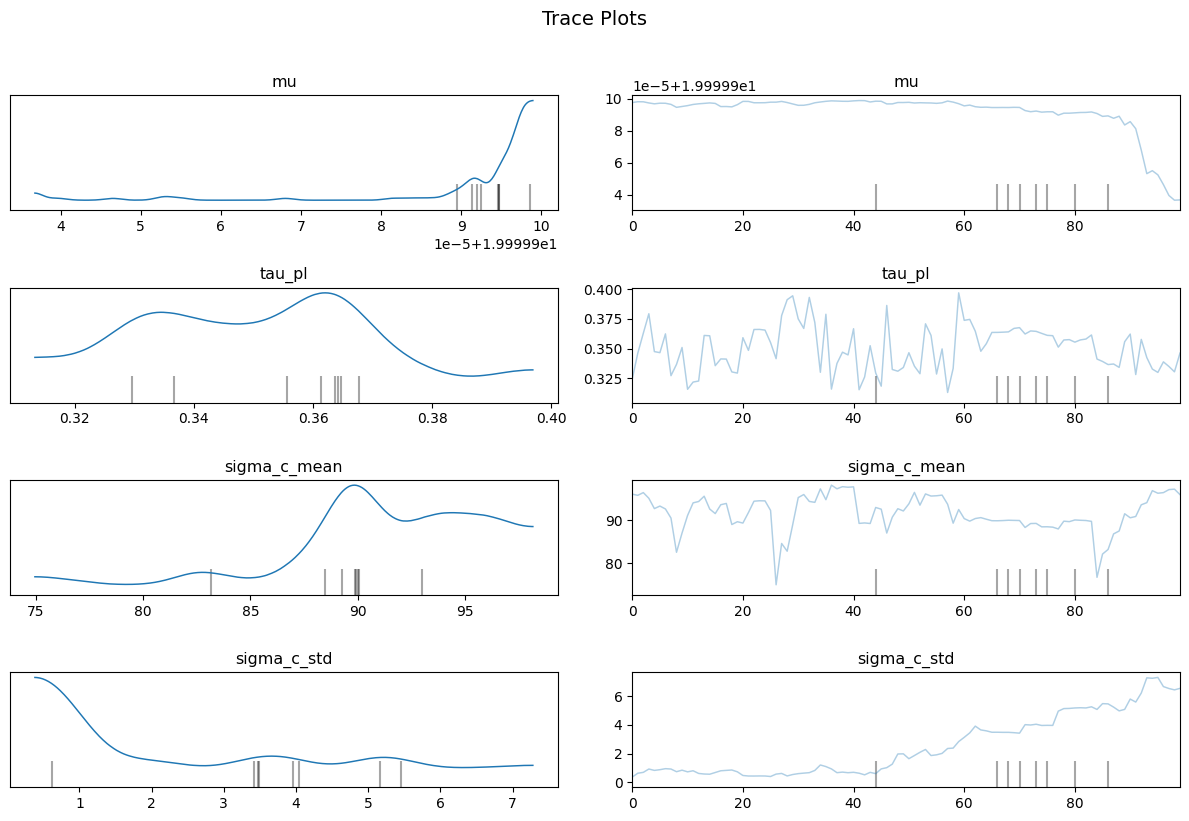

In [11]:
idata = result.to_inference_data()

# Trace plot
axes = az.plot_trace(idata, var_names=param_names, figsize=(12, 8))
fig = axes.ravel()[0].figure
fig.suptitle("Trace Plots", fontsize=14, y=1.02)
plt.tight_layout()
display(fig)
plt.close(fig)

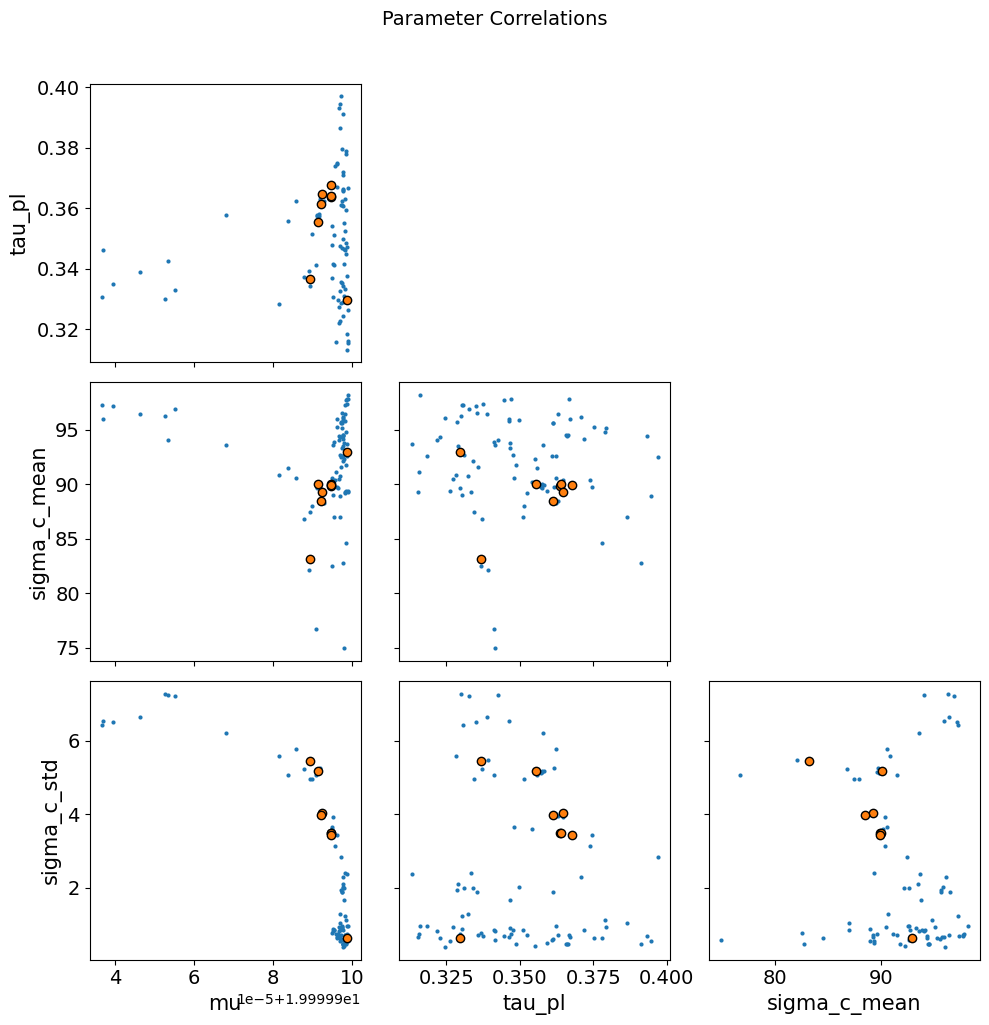

In [12]:
# Pair plot (parameter correlations)
axes = az.plot_pair(
    idata,
    var_names=param_names,
    kind="scatter",
    divergences=True,
    figsize=(10, 10),
)
fig = axes.ravel()[0].figure
fig.suptitle("Parameter Correlations", fontsize=14, y=1.02)
plt.tight_layout()
display(fig)
plt.close(fig)

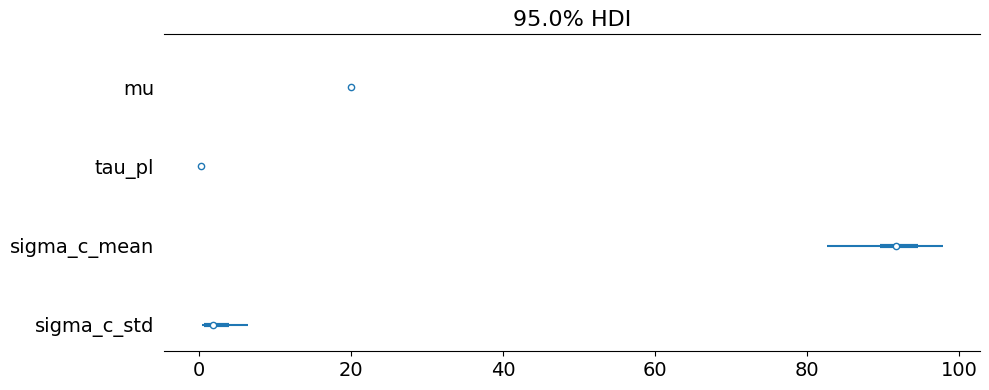

In [13]:
# Forest plot (credible intervals)
axes = az.plot_forest(
    idata,
    var_names=param_names,
    combined=True,
    hdi_prob=0.95,
    figsize=(10, 4),
)
fig = axes.ravel()[0].figure
plt.tight_layout()
display(fig)
plt.close(fig)

In [14]:
# Energy plot (NUTS-specific)
if NUM_CHAINS > 1:
    axes = az.plot_energy(idata, figsize=(8, 4))
    fig = axes.ravel()[0].figure if hasattr(axes, 'ravel') else plt.gcf()
    plt.tight_layout()
    display(fig)
    plt.close(fig)
else:
    print("Energy plot requires multiple chains. Run with NUM_CHAINS=4 for full diagnostics.")

Energy plot requires multiple chains. Run with NUM_CHAINS=4 for full diagnostics.


## 9. Posterior Predictive Check

In [15]:
# Get credible intervals
intervals = model.get_credible_intervals(
    result.posterior_samples, credibility=0.95
)

# Sample posterior predictions
posterior = result.posterior_samples
# --- FAST mode: 10 draws for quick validation ---
# --- FULL mode: 100 draws for publication-quality CI bands ---
FAST_POSTERIOR_PREDICTIVE = True  # Set to False for full analysis

if FAST_POSTERIOR_PREDICTIVE:
    n_draws = min(10, len(list(posterior.values())[0]))
else:
    n_draws = min(100, len(list(posterior.values())[0]))
gamma_dot_pred = np.logspace(
    np.log10(gamma_dot.min()) - 0.3,
    np.log10(gamma_dot.max()) + 0.2,
    50,
)

# Draw posterior predictive samples
print(f"Computing {n_draws} posterior predictive samples...")
pred_samples = []
for i in range(n_draws):
    # Set parameters from posterior
    for name in param_names:
        model.parameters.set_value(name, float(posterior[name][i]))
    
    # Predict
    pred_i = model.predict(gamma_dot_pred, test_mode="flow_curve", smooth=True).y
    pred_samples.append(np.array(pred_i))

pred_samples = np.array(pred_samples)
pred_median = np.median(pred_samples, axis=0)
pred_lo = np.percentile(pred_samples, 2.5, axis=0)
pred_hi = np.percentile(pred_samples, 97.5, axis=0)

print("Done.")

Computing 10 posterior predictive samples...


Done.


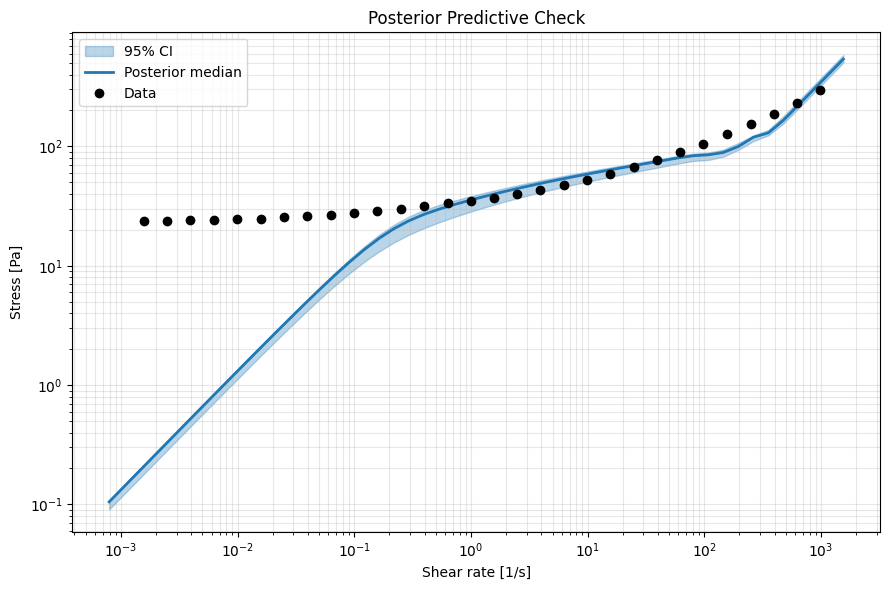

In [16]:
fig, ax = plt.subplots(figsize=(9, 6))
ax.fill_between(
    gamma_dot_pred, pred_lo, pred_hi, alpha=0.3, color="C0", label="95% CI"
)
ax.loglog(gamma_dot_pred, pred_median, "-", lw=2, color="C0", label="Posterior median")
ax.loglog(gamma_dot, stress, "ko", markersize=6, label="Data")
ax.set_xlabel("Shear rate [1/s]")
ax.set_ylabel("Stress [Pa]")
ax.set_title("Posterior Predictive Check")
ax.legend()
ax.grid(True, alpha=0.3, which="both")
plt.tight_layout()
display(fig)
plt.close(fig)

## 10. TensorialEPM Forward Predictions (Sidebar)

The **TensorialEPM** model tracks the full stress tensor [σ_xx, σ_yy, σ_xy], enabling prediction of **normal stress differences** N₁ = σ_xx - σ_yy.

**Note:** TensorialEPM currently supports forward predictions only (fitting is not yet implemented). We use the parameters calibrated from LatticeEPM.

In [17]:
# Get median parameters from posterior
median_params = {name: float(np.median(posterior[name])) for name in param_names}
print("Using median posterior parameters:")
for k, v in median_params.items():
    print(f"  {k}: {v:.4g}")

Using median posterior parameters:
  mu: 20
  tau_pl: 0.3512
  sigma_c_mean: 91.67
  sigma_c_std: 1.871


In [18]:
# Create TensorialEPM with calibrated parameters
model_tensor = TensorialEPM(
    L=16 if FAST_MODE else 32,
    dt=0.01,
    mu=median_params["mu"],
    nu=0.48,
    tau_pl=median_params["tau_pl"],
    sigma_c_mean=median_params["sigma_c_mean"],
    sigma_c_std=median_params["sigma_c_std"],
)

# Predict flow curve with N₁
print("Running TensorialEPM forward prediction...")
result_tensor = model_tensor.predict(gamma_dot_fine, test_mode="flow_curve", smooth=True, seed=42)

sigma_xy_tensor = result_tensor.y
N1_tensor = result_tensor.metadata.get("N1", np.zeros_like(sigma_xy_tensor))

print(f"σ_xy range: {np.min(sigma_xy_tensor):.2f} – {np.max(sigma_xy_tensor):.2f} Pa")
print(f"N₁ range: {np.min(N1_tensor):.2f} – {np.max(N1_tensor):.2f} Pa")

Running TensorialEPM forward prediction...


σ_xy range: 0.08 – 232700.41 Pa
N₁ range: -0.00 – 0.00 Pa


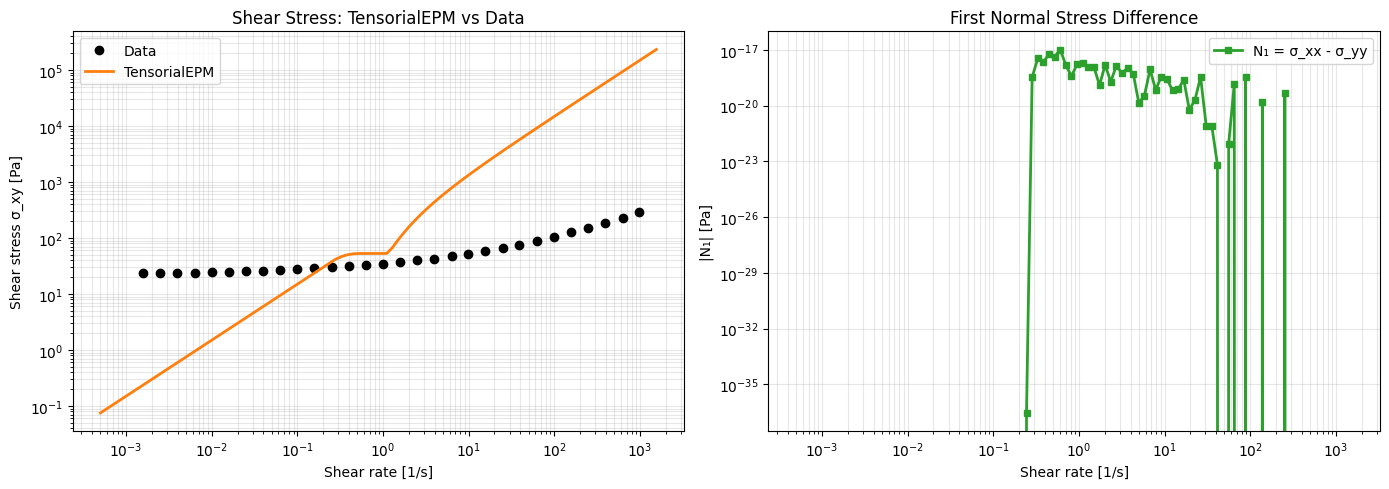

In [19]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Shear stress comparison
ax1.loglog(gamma_dot, stress, "ko", markersize=6, label="Data")
ax1.loglog(gamma_dot_fine, sigma_xy_tensor, "-", lw=2, color="C1", label="TensorialEPM")
ax1.set_xlabel("Shear rate [1/s]")
ax1.set_ylabel("Shear stress σ_xy [Pa]")
ax1.set_title("Shear Stress: TensorialEPM vs Data")
ax1.legend()
ax1.grid(True, alpha=0.3, which="both")

# Normal stress difference
ax2.loglog(gamma_dot_fine, np.abs(N1_tensor), "s-", lw=2, color="C2", markersize=4, label="N₁ = σ_xx - σ_yy")
ax2.set_xlabel("Shear rate [1/s]")
ax2.set_ylabel("|N₁| [Pa]")
ax2.set_title("First Normal Stress Difference")
ax2.legend()
ax2.grid(True, alpha=0.3, which="both")

plt.tight_layout()
display(fig)
plt.close(fig)

## 11. Save Results

Save the calibrated parameters for use in Notebook 03 (synthetic startup data generation).

In [20]:
import json

output_dir = os.path.join("..", "outputs", "epm", "flow_curve")
os.makedirs(output_dir, exist_ok=True)

# Save NLSQ point estimates (reset to fitted values)
for name in param_names:
    model.parameters.set_value(name, float(np.median(posterior[name])))

nlsq_params = {
    name: float(model.parameters.get_value(name))
    for name in model.parameters.keys()
}
with open(os.path.join(output_dir, "nlsq_params.json"), "w") as f:
    json.dump(nlsq_params, f, indent=2)

# Save posterior samples
posterior_dict = {k: np.array(v).tolist() for k, v in posterior.items()}
with open(os.path.join(output_dir, "posterior_samples.json"), "w") as f:
    json.dump(posterior_dict, f)

print(f"Results saved to {output_dir}/")
print(f"  nlsq_params.json: {len(nlsq_params)} parameters")
print(f"  posterior_samples.json: {n_draws} draws")

Results saved to ../outputs/epm/flow_curve/
  nlsq_params.json: 5 parameters
  posterior_samples.json: 10 draws


## 12. Key Takeaways

1. **EPM captures yield stress physics** via disorder-induced yielding thresholds and plastic avalanches
2. **LatticeEPM** supports full NLSQ + Bayesian fitting; **TensorialEPM** adds normal stress predictions
3. **NLSQ warm-start is critical** for NUTS convergence on this complex model
4. **μ and σ_c,mean** are the most directly interpretable parameters (modulus and yield stress)
5. **τ_pl and σ_c,std** control dynamics and disorder — may show correlations in the posterior
6. **Normal stress N₁** from TensorialEPM provides additional insight into microstructural anisotropy

## Next Steps

- **Notebook 02**: Fit SAOS (oscillation) data with EPM
- **Notebook 03**: Use calibrated parameters to generate synthetic startup data and observe stress overshoot
- **Notebook 06**: Explore the EPM visualization gallery (stress fields, avalanche animations)